### Trainin CaDRReS model and use the model for predicting drug response

This example shows how to predicting drug respons using the GDSC model. Input file is a gene exression matrix.

1. Normalize gene expression
2. Choose model specification and train a model using full dataset (use CCLE as an example).
3. Train CaDRRReS model

#### Read gene expression file and calculate kernel features


In [2]:
import sys, os, pickle
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)
from collections import Counter
import importlib

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
mpl.rc("savefig", dpi=300)

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

scriptpath = '..'
sys.path.append(os.path.abspath(scriptpath))

from cadrres import pp, model, evaluation, utility

##### Normalize gene expression and calculate kernel feature based on GDSC sample

Read gene expression

In [3]:
gdsc_sample_list = pd.read_csv('../data/GDSC/gdsc_all_abs_ic50_bayesian_sigmoid_only9dosages.csv', index_col=0).index.astype(str)

In [5]:
len(gdsc_sample_list)

(1074, 42)

In [16]:
gdsc_drug_df = pd.read_csv('../preprocessed_data/GDSC/hn_drug_stat.csv', index_col=0)
gdsc_drug_df.index = gdsc_drug_df.index.astype(str)
drug_list = gdsc_drug_df.index
gdsc_drug_df.shape

(81, 27)

Normalized each gene based on all 1,018 GDSC cell lines

In [8]:
gdsc_log2_exp_df = pd.read_csv('../data/GDSC/GDSC_exp.tsv', sep='\t', index_col=0)
gdsc_log2_exp_df.shape

(17737, 1018)

In [9]:
gdsc_norm_exp_df, gdsc_mean_exp_df = pp.gexp.normalize_log2_mean_fc(gdsc_log2_exp_df)

In [11]:
ess_gene_list = utility.get_gene_list('../data/essential_genes.txt')

gdsc_gene_list = list(gdsc_log2_exp_df.index)
selected_gene_list = [g for g in ess_gene_list if g in gdsc_gene_list]
len(selected_gene_list)

1610

Calculate kernel feature based on all 985 GDSC samples with both gene expression and drug response profiles

In [12]:
train_feature_df = pp.gexp.calculate_kernel_feature(gdsc_norm_exp_df, gdsc_norm_exp_df, selected_gene_list)
train_feature_df.shape

Calculating kernel features based on 1610 common genes
(17737, 1018) (17737, 1018)
100 of 1018 (20.52)s
200 of 1018 (19.59)s
300 of 1018 (21.49)s
400 of 1018 (17.92)s
500 of 1018 (23.27)s
600 of 1018 (22.91)s
700 of 1018 (21.94)s
800 of 1018 (20.55)s
900 of 1018 (21.64)s
1000 of 1018 (26.25)s


(1018, 1018)

In [13]:
gdsc_sample_list = [s for s in gdsc_sample_list if s in train_feature_df.index]

train_feature_df = train_feature_df.loc[gdsc_sample_list, gdsc_sample_list]
print (train_feature_df.shape)

(985, 985)


In [14]:
train_feature_df.to_csv('../preprocessed_data/HN_model/train_feature_df.csv')

#### Read drug response

In [19]:
gdsc_obs_df = pd.read_csv('../data/GDSC/gdsc_all_abs_ic50_bayesian_sigmoid_only9dosages.csv', index_col=0)
gdsc_obs_df.index = gdsc_obs_df.index.astype(str)
gdsc_obs_df = gdsc_obs_df[drug_list]
gdsc_obs_df.shape

(1074, 81)

In [20]:
train_resp_df = gdsc_obs_df

In [21]:
train_sample_list = list(set(train_resp_df.index).intersection(train_feature_df.index))

1372 Tramitinib was tested for 5 dosages

In [23]:
tested_drug_list = ['1032', '201', '182', '1007', '1372', '301', '302']
print ([d for d in tested_drug_list if d in drug_list])

['1032', '201', '182', '1007', '301', '302']


##### Prepare x0 for calculating logistic sample weight

In [24]:
sample_weights_logistic_x0_df = model.get_sample_weights_logistic_x0(gdsc_drug_df, 'log2_max_conc', train_sample_list)
sample_weights_logistic_x0_df.head()

Drug ID,1001,1003,1004,1006,1007,1010,1012,1014,1015,1016,...,299,301,302,303,305,306,308,328,331,346
684055,10.965784,-3.321928,-3.321928,1.0,-6.321928,-1.0,3.321928,2.321928,3.321928,-2.321928,...,4.321928,3.356144,3.356144,4.321928,4.321928,3.356144,2.356144,1.356144,3.356144,1.321928
753556,10.965784,-3.321928,-3.321928,1.0,-6.321928,-1.0,3.321928,2.321928,3.321928,-2.321928,...,4.321928,3.356144,3.356144,4.321928,4.321928,3.356144,2.356144,1.356144,3.356144,1.321928
906801,10.965784,-3.321928,-3.321928,1.0,-6.321928,-1.0,3.321928,2.321928,3.321928,-2.321928,...,4.321928,3.356144,3.356144,4.321928,4.321928,3.356144,2.356144,1.356144,3.356144,1.321928
906877,10.965784,-3.321928,-3.321928,1.0,-6.321928,-1.0,3.321928,2.321928,3.321928,-2.321928,...,4.321928,3.356144,3.356144,4.321928,4.321928,3.356144,2.356144,1.356144,3.356144,1.321928
688023,10.965784,-3.321928,-3.321928,1.0,-6.321928,-1.0,3.321928,2.321928,3.321928,-2.321928,...,4.321928,3.356144,3.356144,4.321928,4.321928,3.356144,2.356144,1.356144,3.356144,1.321928


##### Prepare indication weight

In [25]:
indication_specific_degree = 10

indication_weight_df = pd.DataFrame(np.ones(train_resp_df.shape), index=train_resp_df.index, columns=train_resp_df.columns)
indication_weight_df.loc[gdsc_hn_sample_list, :] = indication_weight_df.loc[gdsc_hn_sample_list, :] * indication_specific_degree

##### Align sample and drug orders

In [26]:
train_resp_df = train_resp_df.loc[train_sample_list, drug_list]
train_feature_df = train_feature_df.loc[train_sample_list]
logistic_x0_df = sample_weights_logistic_x0_df.loc[train_sample_list, drug_list]
indication_weight_df = indication_weight_df.loc[train_sample_list, drug_list]

#### Train CaDRReS models

In [27]:
output_dir = '../result/HN_model/'

For targeted drugs

In [28]:
importlib.reload(pp)
importlib.reload(model)
importlib.reload(evaluation)
importlib.reload(utility)

<module 'cadrres.utility' from '/Users/Nok/Dropbox/Research/2019_drug_response_heterogeneity/CaDRReS_package/cadrres/utility.py'>

In [31]:
cadrres_model_dict, cadrres_output_dict = model.train_model_logistic_weight(train_resp_df[drug_list], train_feature_df, train_resp_df[drug_list], train_feature_df, logistic_x0_df[drug_list], indication_weight_df[drug_list], 10, 0.0, 100000, 0.01, save_interval=5000, output_dir=output_dir)

W1226 19:12:58.885205 4632995264 deprecation_wrapper.py:119] From /Users/Nok/Dropbox/Research/2019_drug_response_heterogeneity/CaDRReS_package/cadrres/model.py:97: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1226 19:12:58.891062 4632995264 deprecation_wrapper.py:119] From /Users/Nok/Dropbox/Research/2019_drug_response_heterogeneity/CaDRReS_package/cadrres/model.py:110: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1226 19:12:58.939144 4632995264 deprecation_wrapper.py:119] From /Users/Nok/Dropbox/Research/2019_drug_response_heterogeneity/CaDRReS_package/cadrres/model.py:112: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



Getting data ...
Initializing the model ...
Train: 71554 out of 79785


W1226 19:12:59.151503 4632995264 deprecation_wrapper.py:119] From /Users/Nok/Dropbox/Research/2019_drug_response_heterogeneity/CaDRReS_package/cadrres/model.py:477: The name tf.train.GradientDescentOptimizer is deprecated. Please use tf.compat.v1.train.GradientDescentOptimizer instead.

W1226 19:12:59.212411 4632995264 deprecation.py:323] From /Users/Nok/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1226 19:12:59.337471 4632995264 deprecation_wrapper.py:119] From /Users/Nok/Dropbox/Research/2019_drug_response_heterogeneity/CaDRReS_package/cadrres/model.py:479: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.

W1226 19:12:59.341266 4632995264 deprecation_wrapper.py:119] From /Users/Nok/Dropb

Starting model training ...
TF session started ...
Starting 1st iteration ...
MSE train at step 0: 33.716 (0.01m)
MSE train at step 5000: 8.921 (1.57m)
MSE train at step 10000: 7.093 (3.10m)
MSE train at step 15000: 6.528 (4.39m)
MSE train at step 20000: 6.178 (5.68m)
MSE train at step 25000: 5.936 (6.96m)
MSE train at step 30000: 5.735 (8.25m)
MSE train at step 35000: 5.564 (9.54m)
MSE train at step 40000: 5.424 (10.87m)
MSE train at step 45000: 5.304 (12.16m)
MSE train at step 50000: 5.191 (13.46m)
MSE train at step 55000: 5.091 (14.73m)
MSE train at step 60000: 5.023 (16.03m)
MSE train at step 65000: 4.909 (17.31m)
MSE train at step 70000: 4.828 (18.59m)
MSE train at step 75000: 4.763 (19.88m)
MSE train at step 80000: 4.785 (21.17m)
MSE train at step 85000: 4.681 (22.46m)
MSE train at step 90000: 4.614 (23.75m)
MSE train at step 95000: 4.749 (25.02m)
Saving model parameters and predictions ...
DONE


In [32]:
pickle.dump(cadrres_model_dict, open(output_dir + 'hn_drug_cw_dw10_100000_param_dict.pickle', 'wb'))
pickle.dump(cadrres_output_dict, open(output_dir + 'hn_drug_cw_dw10_100000_output_dict.pickle', 'wb'))

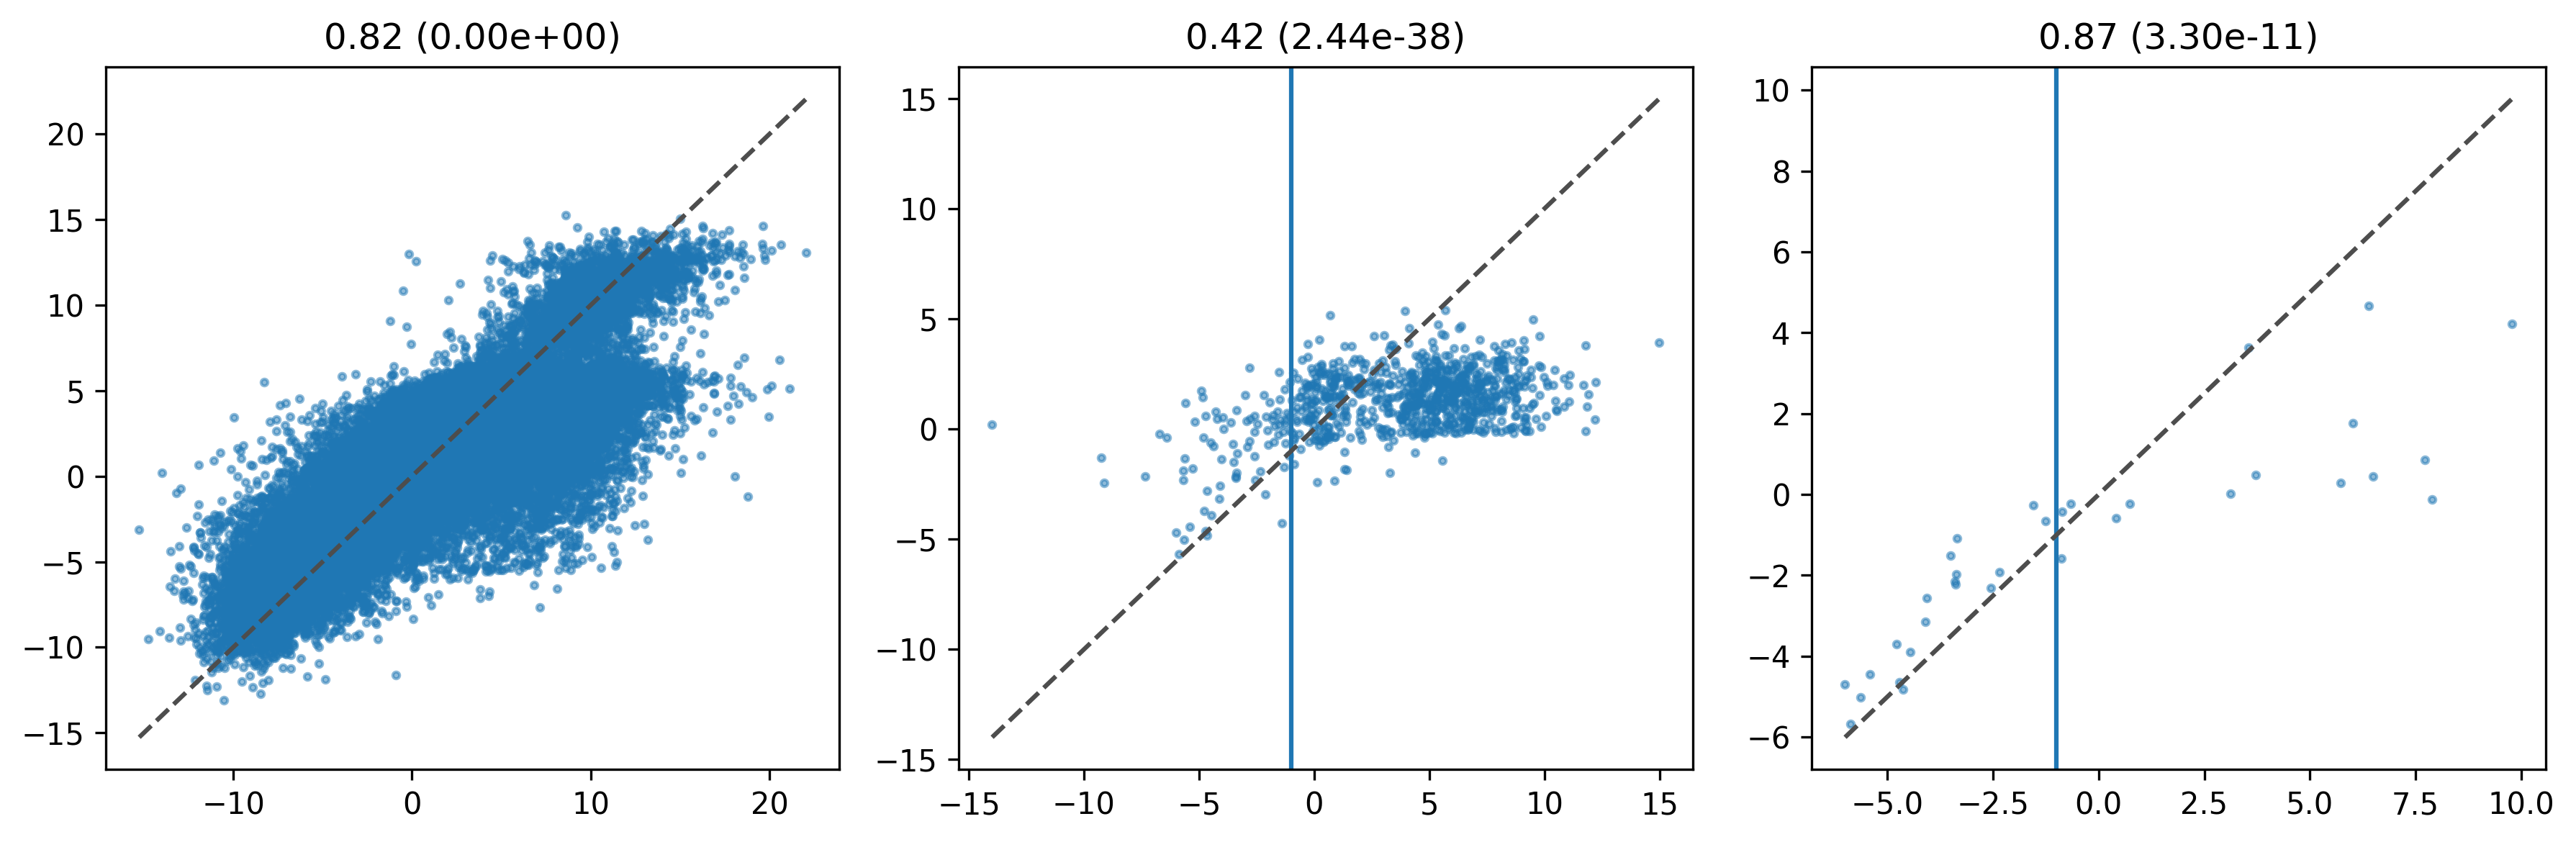

In [33]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=3)

ax = axes[0]
x = np.array(cadrres_output_dict['obs_train_df']).flatten()
y = np.array(cadrres_output_dict['pred_train_df']).flatten()
ax.scatter(x[~np.isnan(x)], y[~np.isnan(x)], s=5, alpha=0.5)

pcor, pval = stats.pearsonr(x[~np.isnan(x)], y[~np.isnan(x)])
ax.set_title("{:.2f} ({:.2e})".format(pcor, pval))

min_val = np.nanmin(x)
max_val = np.nanmax(x)
ax.plot([min_val, max_val], [min_val, max_val], ls="--", c=".3")

drug_id = '1032'

ax = axes[1]
x = np.array(cadrres_output_dict['obs_train_df'][[drug_id]]).flatten()
y = np.array(cadrres_output_dict['pred_train_df'][[drug_id]]).flatten()
ax.scatter(x[~np.isnan(x)], y[~np.isnan(x)], s=5, alpha=0.5)
ax.axvline(x=gdsc_drug_df.loc[drug_id, 'log2_max_conc'])
stats.pearsonr(x[~np.isnan(x)], y[~np.isnan(x)])

min_val = np.nanmin(x)
max_val = np.nanmax(x)
ax.plot([min_val, max_val], [min_val, max_val], ls="--", c=".3")

pcor, pval = stats.pearsonr(x[~np.isnan(x)], y[~np.isnan(x)])
ax.set_title("{:.2f} ({:.2e})".format(pcor, pval))

ax = axes[2]
x = np.array(cadrres_output_dict['obs_train_df'].loc[gdsc_hn_sample_list][[drug_id]]).flatten()
y = np.array(cadrres_output_dict['pred_train_df'].loc[gdsc_hn_sample_list][[drug_id]]).flatten()
ax.scatter(x[~np.isnan(x)], y[~np.isnan(x)], s=5, alpha=0.5)
ax.axvline(x=gdsc_drug_df.loc[drug_id, 'log2_max_conc'])
stats.pearsonr(x[~np.isnan(x)], y[~np.isnan(x)])

min_val = np.nanmin(x)
max_val = np.nanmax(x)
ax.plot([min_val, max_val], [min_val, max_val], ls="--", c=".3")

pcor, pval = stats.pearsonr(x[~np.isnan(x)], y[~np.isnan(x)])
ax.set_title("{:.2f} ({:.2e})".format(pcor, pval))

plt.tight_layout()